# Product Pricing Chart Case Study
## Product A Pricing Chart

- Product A has a raw material cost of around \$7 and takes about 30 - 45 minutes of processing time to complete.
- Product starts at 35 dollars and vendor is charging 5 dollars for each additional color used in construction.


In [65]:
# products start at $35 and cost $5 extra for each additional color
import numpy as np
# Define constants
BASE_PRICE = 35
DEFAULT_LENGTH = 12
DEFAULT_COLOR_NUM = 1
DEFAULT_WEIGHT = 8
MATERIAL_LOSS = 8
MATERIAL_PRICE_LIST = [14.94 / 2, 34.09 / 4, 48.60 / 10, 19.11 / 4]
MATERIAL_PRICE = np.mean(MATERIAL_PRICE_LIST)
print(f"MATERIAL_PRICE: ${MATERIAL_PRICE.round(2)}")

MATERIAL_PRICE: $6.41


### Generating Test Data for analysis
- Product has 3 parameters which can be customized for each user basis. Length, Weight, and Color.
- In my generated test data I am maxing out on a length of 20 inches.

In [66]:
# Generating test data
import pandas as pd

INCHES_PER_UNIT = 15 * 12
weight_list = list(range(6, 13))
length_list = list(range(6, 15))
color_list = list(range(1,10))
data = []

for weight in weight_list:
    for length in length_list:
            for color in color_list:
                if color < weight:
                    data.append([weight, length, color])


df = pd.DataFrame(columns=['weight', 'length', 'num_colors'], data=data)

df.head()

,weight,length,num_colors
0,6,6,1
1,6,6,2
2,6,6,3
3,6,6,4
4,6,6,5


In [67]:
# Adding building stats to df
generated_columns = ['get_segment_length', 'get_num_segments', 'get_num_units_raw']
df_build_stats = df.copy()
df_build_stats['get_segment_length'] = df['length'] + 8
df_build_stats['get_num_segments'] = df['weight'] / 2
df_build_stats['get_segments_per_color'] = df_build_stats['get_num_segments'] / df['num_colors']
df_build_stats['get_total_length'] = df_build_stats['get_segment_length'] * df_build_stats['get_num_segments']
df_build_stats['get_num_units_raw'] = df_build_stats['get_total_length'] / INCHES_PER_UNIT
df_build_stats['get_length_per_color'] = df_build_stats['get_segment_length'] * df_build_stats['get_num_segments']



#### Segment Length vs Material Count

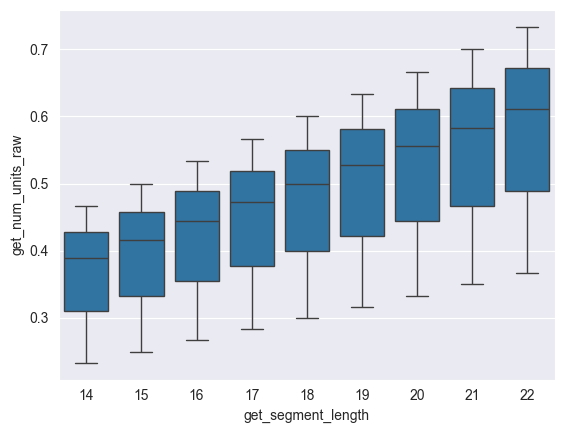

In [68]:
import seaborn as sns

sns.boxplot(data=df_build_stats, x='get_segment_length', y='get_num_units_raw');

In [69]:
# Verifying that there is still a profit margin in the worst case scenarios.
df_price = df.copy()
COST_PER_UNIT = (15 / 2) + 8 #Two units per order plus shipping and handling
PROCESS_TIME_PER_ORDER = .45
COST_PER_COLOR = 5
df_price['price'] = 35 + df_price['num_colors'] * COST_PER_COLOR
df_price['num_units'] = df_build_stats['get_num_units_raw'].round(1) * df_build_stats['num_colors']
df_price['num_units_rounded'] = np.ceil(df_build_stats['get_num_units_raw'] * 4)/4 * df_build_stats['num_colors']
df_price['material_loss'] = df_price['num_units_rounded'] - df_price['num_units']
df_price['material_length'] = df_build_stats['get_segment_length'] * df_build_stats['get_num_segments']
df_price['cost']= df_price['num_units'] * COST_PER_UNIT
df_price['profit']= df_price['price'] - df_price['cost']
df_price.head()


,weight,length,num_colors,price,num_units,num_units_rounded,material_loss,material_length,cost,profit
0,6,6,1,40,0.2,0.25,0.05,42.0,3.1,36.9
1,6,6,2,45,0.4,0.50,0.10,42.0,6.2,38.8
2,6,6,3,50,0.6,0.75,0.15,42.0,9.3,40.7
3,6,6,4,55,0.8,1.00,0.20,42.0,12.4,42.6
4,6,6,5,60,1.0,1.25,0.25,42.0,15.5,44.5


#### Lowest Profit Items

In [70]:
df_price.sort_values(by=['profit'], ascending=True, inplace=True)
df_price.head()

,weight,length,num_colors,price,num_units,num_units_rounded,material_loss,material_length,cost,profit
476,12,14,9,80,6.3,6.75,0.45,132.0,97.65,-17.65
458,12,12,9,80,6.3,6.75,0.45,120.0,97.65,-17.65
467,12,13,9,80,6.3,6.75,0.45,126.0,97.65,-17.65
395,11,14,9,80,6.3,6.75,0.45,121.0,97.65,-17.65
457,12,12,8,75,5.6,6.00,0.40,120.0,86.80,-11.80


In [71]:
meanProfit = df_price.profit.mean()
print("Lowest Profit: ",df_price.profit.min().round(1))
print("Highest Profit: ",df_price.profit.max().round(2))
print("Mean Profit: ",df_price.profit.mean().round(2))
print("Median Profit: ",df_price.profit.median().round(2))
print("Hourly Profit: ", (df_price.profit.mean() / PROCESS_TIME_PER_ORDER).round(2))
print("Mean Material Loss: ",df_price.material_loss.mean().round(2))

Lowest Profit:  -17.6
Highest Profit:  44.5
Mean Profit:  23.81
Median Profit:  27.8
Hourly Profit:  52.91
Mean Material Loss:  0.49


#### Observations
- There is only a negative profit on one of the items in the chart it used some fairly unrealistic values.
- The mean profit for this data set is 23.81
- The units with the lowest profit all have weight > 10 and length > 11
- The mean material loss is 0.16 units, but assumes the client doesn't reuse any scrap materials.


### Profit Graph Plots

#### Profit by count

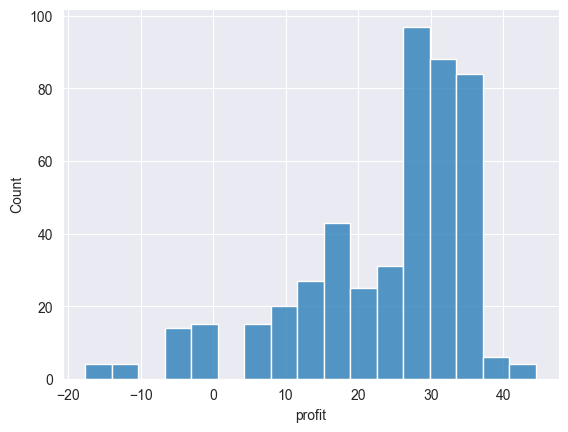

In [72]:
sns.histplot(x='profit', data=df_price);

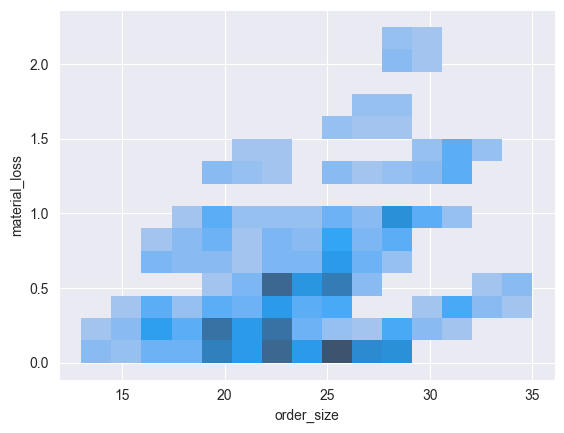

In [73]:
# Creating single metric for order size for future graphs
df_price['order_size'] = df_price['length'] + df_price['weight'] + df_price['num_colors']
sns.histplot(data=df_price, x='order_size', y='material_loss');

### Observations
- As order size goes up material_loss goes up.

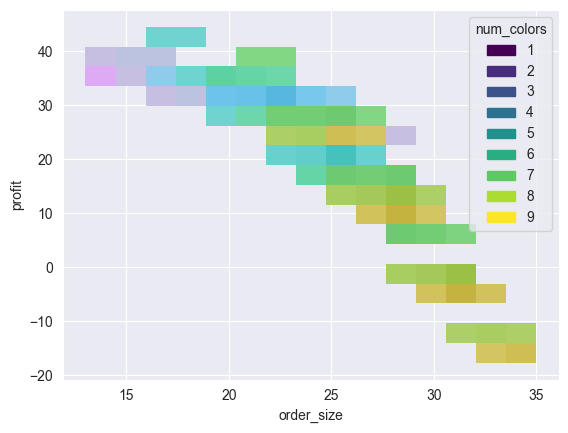

In [74]:
sns.histplot(data=df_price, x='order_size', y='profit', hue='num_colors', palette='viridis');

### Observations
- When order_size is over 25 orders stop being profitable.
- order_size is easy to calculate on the fly as it just involves adding the 3 dimensions.

### Proposal
- Add a 15 dollar surcharge for orders with order_size over 25

In [88]:
df_price2 = df_price.copy()
df_price2.loc[df_price['order_size'] > 25, 'price' ] = df_price['price'] + 15
df_price2.loc[df_price['order_size'] > 25, 'profit' ] = df_price['profit'] + 15
price_stats = ['order_size', 'price', 'profit']
df_price2[price_stats]

,order_size,price,profit
476,35,95,-2.65
458,33,95,-2.65
467,34,95,-2.65
395,34,95,-2.65
457,32,90,3.20
...,...,...,...
2,15,50,40.70
8,17,55,42.60
3,16,55,42.60
9,18,60,44.50


### Observations
- A 15 dollar surchare is enough to cover the extra material cost on all but the largest orders.

### Profit by order size

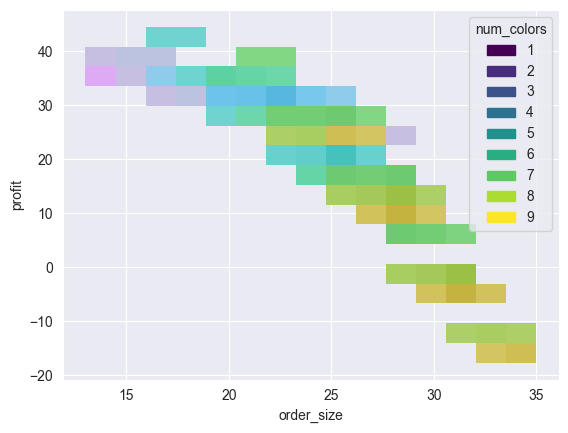

In [85]:
sns.histplot(data=df_price, x='order_size', y='profit', hue='num_colors', palette='viridis');

### New Profit Chart

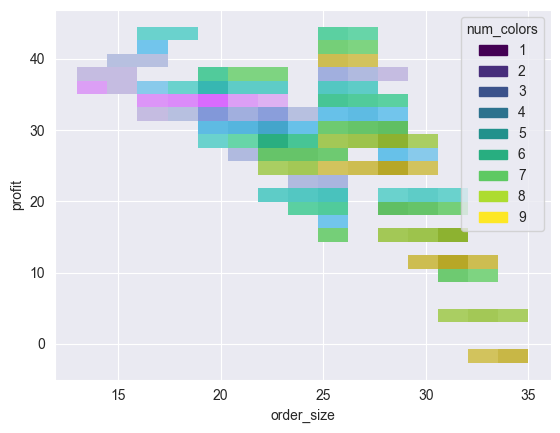

In [89]:
sns.histplot(data=df_price2, x='order_size', y='profit', hue='num_colors', palette='viridis');

In [79]:
df_price2 = df_price

### Conclusion
- Based on the observations this product should be fairly profitable for the client.
- Client should do additional research to find the best place to market their product.
- Vendor could eliminate unprofitable sales in the following ways:
- A. Adding a surcharge for orders with order_size > 25
- B. Putting a max limit on values for order_size.
